In [60]:
#importing necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
import wget
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from collections import Counter

In [61]:
#url to load data directly from the web
#wget https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
#unzip data

In [62]:
#loading the data
datapath = os.path.join("D:/machine learning/NLP/plagarism/Data/data")
csv_file = os.path.join(datapath,"file_information.csv")
data = pd.read_csv(csv_file)
data.head(10)

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
5,g0pB_taska.txt,a,non
6,g0pB_taskb.txt,b,non
7,g0pB_taskc.txt,c,cut
8,g0pB_taskd.txt,d,light
9,g0pB_taske.txt,e,heavy


### Exploratory data analysis

In [63]:
#checking for any missing values in the data
data.isna().sum()

File        0
Task        0
Category    0
dtype: int64

* There are no missing values in the data

In [64]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   File      100 non-null    object
 1   Task      100 non-null    object
 2   Category  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB
None


In [65]:
print(f"The no of files in the dataset are {len(data)}")
print(f"The number of unique tasks in the are {data['Task'].nunique()}\nUnique tasks:{data['Task'].unique()}")
print(f"Number of plagiarism categories are {data['Category'].nunique()}\nUnique categories:{data['Category'].unique()}")

The no of files in the dataset are 100
The number of unique tasks in the are 5
Unique tasks:['a' 'b' 'c' 'd' 'e']
Number of plagiarism categories are 5
Unique categories:['non' 'cut' 'light' 'heavy' 'orig']


In [66]:
print("Count of files for each type of task")
display(pd.DataFrame(data['Task'].value_counts()))

Count of files for each type of task


,Task
a,20
b,20
c,20
d,20
e,20


* Different task here indicates the different set of questions.
* There are 5 set of questions i,e(a,b,c,d,e).

In [67]:
print("Count of files for each type of category")
display(pd.DataFrame(data['Category'].value_counts()))

Count of files for each type of category


,Category
non,38
cut,19
light,19
heavy,19
orig,5


* The orig in the category refers to the source text for each type of task i,e(a,b,c,d,e) and will be used to compare each answers with this source file(wikipedia source file).
* The non category refers that the file or data is not plagiarised.
* The other three categories that are cut>light>heavy indicates that the document/answers are plagiarised.
   
   **Cut** *indicates copy pasted plagiarism*
   
   **light** *indicates that the answer/document includes some sort of copying and paraphrasing from the source*
   
   **Heavy** *indicates that the document/answer is taken from the source but changing some of the words and also the structure(challenging type of plagiarism and hard to detect)*
   

In [68]:
#grouping the data based on task and category level of  plagiarism
task_cat_plagiarism=data.groupby(['Task','Category']).agg("count")
task_cat_plagiarism

File
Task Category      
a    cut          4
     heavy        3
     light        3
     non          9
     orig         1
b    cut          3
     heavy        4
     light        3
     non          9
     orig         1
c    cut          3
     heavy        5
     light        4
     non          7
     orig         1
d    cut          4
     heavy        4
     light        5
     non          6
     orig         1
e    cut          5
     heavy        3
     light        4
     non          7
     orig         1

Text(0.5, 1.0, 'Distribution of plagiarism category across different task')

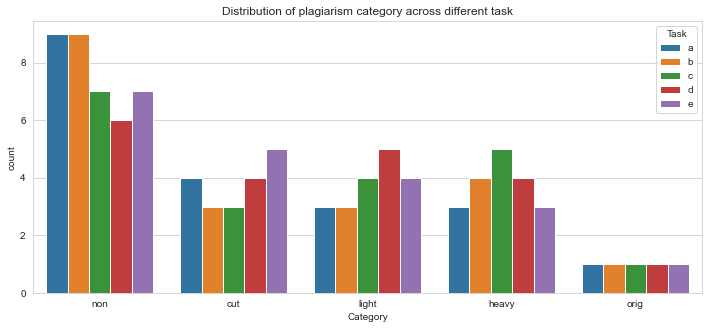

In [69]:
plt.figure(figsize=(12,5))
sns.countplot(data['Category'],hue=data['Task'])
plt.title("Distribution of plagiarism category across different task")

In [70]:
#converting the Category column into numerical representations
#indicating orig with -1 because it is a source document
#assigning numerical values based on the level of plagiarism i,e higher value for higher degree of plagiarism
category_map = {'non':0,'cut':3,'light':2,'heavy':1,'orig':-1} 
data['Category']=data['Category'].map(category_map)

In [71]:
#creating new column to indicate plagiarism {0 for no,1 for yes,-1 for source document}
data['class'] = data['Category'].apply(lambda x:1 if x in [1,2,3] else x)

In [72]:
data

,File,Task,Category,class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
...,...,...,...,...
95,orig_taska.txt,a,-1,-1
96,orig_taskb.txt,b,-1,-1
97,orig_taskc.txt,c,-1,-1
98,orig_taskd.txt,d,-1,-1


In [73]:
#creating a function to extract text data from textfiles
def extract_data_from_txt(filename):
    path = os.path.join(datapath,filename)
    try:
        text = open(path).read()
    except UnicodeDecodeError: #to handle error related to encoding
        text = open(path,encoding='utf-8').read()
        return text
    else:
        return text

In [74]:
#extracting data into nthe new column in the dataframe
data['FileText'] = data['File'].apply(extract_data_from_txt)

In [75]:
data

,File,Task,Category,class,FileText
0,g0pA_taska.txt,a,0,0,Inheritance is a basic concept of Object-Orien...
1,g0pA_taskb.txt,b,3,1,PageRank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,"The vector space model (also called, term vect..."
3,g0pA_taskd.txt,d,1,1,Bayes’ theorem was names after Rev Thomas Baye...
4,g0pA_taske.txt,e,0,0,Dynamic Programming is an algorithm design tec...
...,...,...,...,...,...
95,orig_taska.txt,a,-1,-1,"In object-oriented programming, inheritance is..."
96,orig_taskb.txt,b,-1,-1,PageRank is a link analysis algorithm used by ...
97,orig_taskc.txt,c,-1,-1,Vector space model (or term vector model) is a...
98,orig_taskd.txt,d,-1,-1,"In probability theory, Bayes' theorem (often c..."


In [76]:
#visualising the text in the file
print(data['FileText'][0])

Inheritance is a basic concept of Object-Oriented Programming where
the basic idea is to create new classes that add extra detail to
existing classes. This is done by allowing the new classes to reuse
the methods and variables of the existing classes and new methods and
classes are added to specialise the new class. Inheritance models the
“is-kind-of” relationship between entities (or objects), for example,
postgraduates and undergraduates are both kinds of student. This kind
of relationship can be visualised as a tree structure, where ‘student’
would be the more general root node and both ‘postgraduate’ and
‘undergraduate’ would be more specialised extensions of the ‘student’
node (or the child nodes). In this relationship ‘student’ would be
known as the superclass or parent class whereas, ‘postgraduate’ would
be known as the subclass or child class because the ‘postgraduate’
class extends the ‘student’ class.

Inheritance can occur on several layers, where if visualised would
display

### Feature Engineering
* To know whether a document/answer has been plagiarized or not we have to check the similarity between the document and the source.
* To check this similarity we have to extract the similarity features
* Some of the similarity features that are considered for the feature extraction are:
        * Containment Features
        * Longest Common Subsequence

In [77]:
#extracting the original(source) files from the data and creating a seperate dataframe
sources = pd.DataFrame(data.iloc[95:,:]).reset_index(drop=True)

#removing the unnecessary columns
sources.drop(['Category','class'],axis=1,inplace=True)

#changing the column names
sources.rename(columns={'FileText':"SourceText"},inplace=True)

sources

,File,Task,SourceText
0,orig_taska.txt,a,"In object-oriented programming, inheritance is..."
1,orig_taskb.txt,b,PageRank is a link analysis algorithm used by ...
2,orig_taskc.txt,c,Vector space model (or term vector model) is a...
3,orig_taskd.txt,d,"In probability theory, Bayes' theorem (often c..."
4,orig_taske.txt,e,"In mathematics and computer science, dynamic p..."


In [78]:
#removing the sources from the original dataframe
#removing last 5 rows which are the source document
data_cleaned = data.iloc[:95,:]
data_cleaned

,File,Task,Category,class,FileText
0,g0pA_taska.txt,a,0,0,Inheritance is a basic concept of Object-Orien...
1,g0pA_taskb.txt,b,3,1,PageRank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,"The vector space model (also called, term vect..."
3,g0pA_taskd.txt,d,1,1,Bayes’ theorem was names after Rev Thomas Baye...
4,g0pA_taske.txt,e,0,0,Dynamic Programming is an algorithm design tec...
...,...,...,...,...,...
90,g4pE_taska.txt,a,1,1,Object oriented programming is a style of pro...
91,g4pE_taskb.txt,b,2,1,PageRankalgorithm is also known as link analys...
92,g4pE_taskc.txt,c,3,1,The definition of term depends on the applicat...
93,g4pE_taskd.txt,d,0,0,"""Bayes' Theorem"" or ""Bayes' Rule"", or somethin..."


In [79]:
#creating a function to extract the source text for the given answer file
def get_doc_and_Source(dataframe,filename):
    doc_text = dataframe['FileText'][dataframe['File']==filename].iloc[0]
    task_code = dataframe['Task'][dataframe['File']==filename].iloc[0]
    source_text = sources['SourceText'][sources['Task']==task_code].iloc[0]
    return doc_text,source_text

In [80]:
#creating a function to create containment features and containment calculation
#setting the default Ngram range to 3 
def containment_feat_and_calc(dataframe,filename,n=3):
    doc_text,source_text = get_doc_and_Source(dataframe,filename)
    cv = CountVectorizer(analyzer='word',ngram_range=(n,n))
    vocab = cv.fit([doc_text,source_text]).vocabulary_
    #extracting the features
    counts = cv.fit_transform([doc_text,source_text]).toarray()
    #to get the intersection 
    intersection = np.amin(counts,axis=0)
    #calculating the sum of intersection
    summed_int = np.sum(intersection)
    # no of ngrams in answer(denominator)
    ans_ngram_count = np.sum(counts[0])
    return summed_int/ans_ngram_count 

In [81]:
"""creating a function to extract the normalized longest common subsequence
value by taking test and source document as input"""
def longest_common_sub(dataframe,filename):
    doc_text,source_text=get_doc_and_Source(dataframe,filename)
    doc=doc_text.split()
    source=source_text.split()
    n=len(doc)
    m=len(source)
    matrix = np.zeros((n+1,m+1))
    for i,doc_token in enumerate(doc,start=1):
        for j,soc_token in enumerate(source,start=1):
            if doc_token==soc_token:
                matrix[i,j]=matrix[i-1,j-1]+1
            else:
                matrix[i,j]=max(matrix[i-1,j],matrix[i,j-1])
    lcs_count = matrix[n,m]
    return lcs_count/n

In [82]:
#creating a function to extract features in the form of dataframe
def feature_generator(data,ngram_range,lcs=True):
    """here ngram_range indicates the number of n grams to consider for the containment features"""
    features =pd.DataFrame()
    for i in range(1,ngram_range+1):
        features["ngram_"+str(i)] = [containment_feat_and_calc(data,doc,n=i) for doc in data['File']]
    if lcs:
        features['Normalized_LCS'] = [longest_common_sub(data,doc) for doc in data['File']]
    return features

In [83]:
#extracting the features
features = feature_generator(data_cleaned,ngram_range=8)

In [84]:
features.head(10)

,ngram_1,ngram_2,ngram_3,ngram_4,ngram_5,ngram_6,ngram_7,ngram_8,Normalized_LCS
0,0.398148,0.079070,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667
1,0.994924,0.974490,0.948718,0.922680,0.896373,0.869792,0.842932,0.815789,0.786408
2,0.869369,0.719457,0.613636,0.515982,0.449541,0.382488,0.319444,0.265116,0.745536
3,0.593583,0.268817,0.156757,0.108696,0.081967,0.060440,0.044199,0.027778,0.264249
4,0.544503,0.115789,0.031746,0.005319,0.000000,0.000000,0.000000,0.000000,0.210811
5,0.329502,0.053846,0.007722,0.003876,0.000000,0.000000,0.000000,0.000000,0.141844
6,0.590308,0.150442,0.035556,0.004464,0.000000,0.000000,0.000000,0.000000,0.264000
7,0.765306,0.709898,0.664384,0.625430,0.589655,0.553633,0.520833,0.487805,0.593443
8,0.759777,0.505618,0.395480,0.306818,0.245714,0.195402,0.150289,0.110465,0.419811
9,0.884444,0.526786,0.340807,0.247748,0.180995,0.150000,0.118721,0.091743,0.519313


In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ngram_1         95 non-null     float64
 1   ngram_2         95 non-null     float64
 2   ngram_3         95 non-null     float64
 3   ngram_4         95 non-null     float64
 4   ngram_5         95 non-null     float64
 5   ngram_6         95 non-null     float64
 6   ngram_7         95 non-null     float64
 7   ngram_8         95 non-null     float64
 8   Normalized_LCS  95 non-null     float64
dtypes: float64(9)
memory usage: 6.8 KB


In [86]:
#concatenating the target column i,e class to the features dataframe
features['is_plagiarized'] = data_cleaned['class']

In [121]:
features.head(10)

,ngram_1,ngram_2,ngram_3,ngram_4,ngram_5,ngram_6,ngram_7,ngram_8,Normalized_LCS,is_plagiarized
0,0.398148,0.079070,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0
1,0.994924,0.974490,0.948718,0.922680,0.896373,0.869792,0.842932,0.815789,0.786408,1
2,0.869369,0.719457,0.613636,0.515982,0.449541,0.382488,0.319444,0.265116,0.745536,1
3,0.593583,0.268817,0.156757,0.108696,0.081967,0.060440,0.044199,0.027778,0.264249,1
4,0.544503,0.115789,0.031746,0.005319,0.000000,0.000000,0.000000,0.000000,0.210811,0
5,0.329502,0.053846,0.007722,0.003876,0.000000,0.000000,0.000000,0.000000,0.141844,0
6,0.590308,0.150442,0.035556,0.004464,0.000000,0.000000,0.000000,0.000000,0.264000,0
7,0.765306,0.709898,0.664384,0.625430,0.589655,0.553633,0.520833,0.487805,0.593443,1
8,0.759777,0.505618,0.395480,0.306818,0.245714,0.195402,0.150289,0.110465,0.419811,1
9,0.884444,0.526786,0.340807,0.247748,0.180995,0.150000,0.118721,0.091743,0.519313,1


Text(0.5, 1.0, 'Distribution of target')

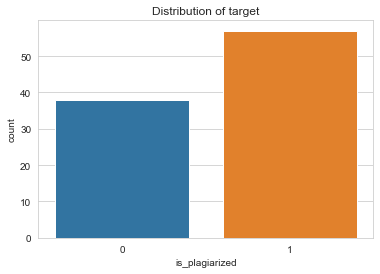

In [179]:
sns.countplot(features['is_plagiarized'])
plt.title("Distribution of target")

* The data is slightly imbalanced
* f1 score will be the best metric to evaluate model since the target class in the data is imbalanced

In [88]:
#saving the features into csv
features.to_csv("Extracted_Features.csv")

#### Creating train and test split

In [148]:
#splitting the data into train and test set
X=features.loc[:,features.columns!='is_plagiarized']
y = features['is_plagiarized']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=717)
print("shape of the training data",x_train.shape)
print("shape of the training data",x_test.shape)
print("Target class distribution in the training set",Counter(y_train))
print("Target class distribution in the testing set",Counter(y_test))

shape of the training data (80, 9)
shape of the training data (15, 9)
Target class distribution in the training set Counter({1: 49, 0: 31})
Target class distribution in the testing set Counter({1: 8, 0: 7})


### Model Building
* Using Random Forest Classifier to build the model

In [149]:
#training the model on the testing data
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [115]:
#creating a function to generate report and to evaluate model on the testing data
def report(model,test_data,actual_labels):
    pred = model.predict(test_data)
    pred_prob = model.predict_proba(test_data)
    fpr,tpr,thresh = roc_curve(actual_labels,pred_prob[:,1],pos_label=1)
    print(f"f1-score: {f1_score(actual_labels,pred)}")
    print(f"AUC Score: {round(roc_auc_score(actual_labels,pred_prob[:,1]),2)}")
    print("Classification report\n",classification_report(actual_labels,pred))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,linestyle="--",color='r')
    plt.title("ROC Curve")
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(actual_labels,pred),annot=True,fmt=".1f")
    plt.title("Confusion Matrix")

In [166]:
print("f1_score for training data:",f1_score(model.predict(x_train),y_train))

f1_score for training data: 1.0


f1-score: 0.9333333333333333
AUC Score: 0.88
Classification report
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



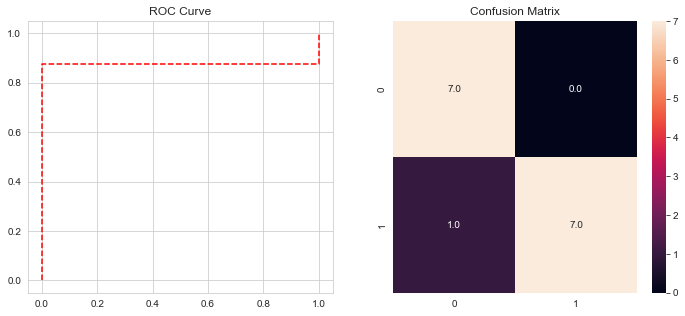

In [154]:
report(model,x_test,y_test)

* The model has a f1 score of 1.0 on training data and 0.93 on the testing data
* The model is slightly overfitting

In [172]:
#cross validation
from sklearn.model_selection import KFold , cross_val_score
cross_val = KFold(n_splits=10,random_state=1,shuffle=True)
scores = cross_val_score(model,X,y,scoring="f1",cv=cross_val,n_jobs=-1)
print("f1_score of the model after cross validation:",round(np.mean(scores),2))

f1_score of the model after cross validation: 0.94


In [159]:
#hyperparameter tuning using Randomized search CV
from sklearn.model_selection import RandomizedSearchCV
params={'n_estimators':[100,200,400,500],
       'max_depth':[2,3,4,5,7,8,10,20,None],
        'min_samples_split':[2,3,5,10,15,20],
        'min_samples_leaf':[1,2,5,10]
       }
model2 = RandomizedSearchCV(model,param_distributions=params,cv=5,n_jobs=-1,scoring="f1",n_iter=100,verbose=1)
model2.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 7, 8, 10, 20,
                                                      None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 3, 5, 10, 15,
                                                              20],
                                        'n_estimators': [100, 200, 400, 500]},
                   scoring='f1', verbose=1)

In [162]:
model2.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_depth': 10}

f1-score: 0.9333333333333333
AUC Score: 0.88
Classification report
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



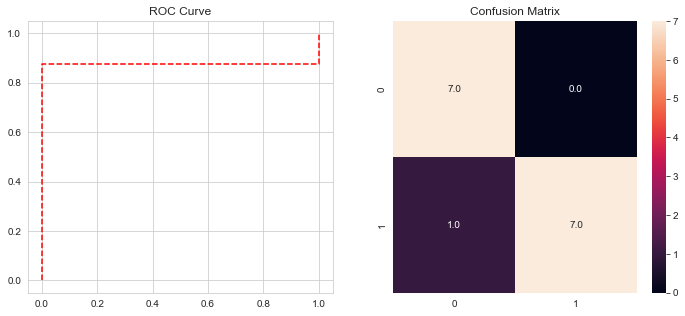

In [173]:
report(model2,x_test,y_test)

In [176]:
print("f1_score on the training data:",round(f1_score(model2.predict(x_train),y_train),2))

f1_score on the training data: 0.98


* for the hyperparameter tuned model, the training f1-score i 0.98 and testing f1-score of 0.93
* The overfitting has been taken cared of, the model is performing well on the data with 94% accuracy

In [178]:
#saving the model
import pickle
pickle.dump(model2,open("finalized_model.pkl","wb"))